# Outline
    preprocessing
        impute base on 2 hour avg
        shift 1 - 12 columns
        feature engineering
    trainning
        model (Nested CV) for each hour, drop specific columns since pm2.5 column with missing value are different for each hour
            Stack
                knn
                rf
                LR
                XGBoost
                SVM

In [191]:
import pandas as pd

file_path = 'data/data.csv'
data = pd.read_csv(file_path, index_col=0)

## data visuallization

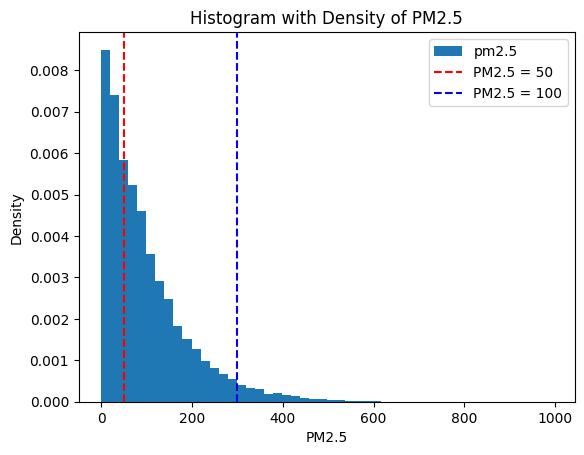

In [192]:
import matplotlib.pyplot as plt

# Adjusted the number of bins to be finer (thinner) by increasing the number
data['pm2.5'].plot(kind='hist', bins=50, density=True, title='Histogram with Density of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Density')
plt.axvline(x=50, color='r', linestyle='--', label='PM2.5 = 50')
plt.axvline(x=300, color='b', linestyle='--', label='PM2.5 = 100')
plt.legend()
plt.show()

In [193]:
# Calculate the percentage of pm2.5 values greater than or equal to 50
pm25_gte_50 = (data['pm2.5'] >= 50).mean() * 100
print(f"Percentage of PM2.5 values >= 50: {pm25_gte_50:.2f}%")

# Calculate the percentage of pm2.5 values greater than or equal to 100
pm25_gte_100 = (data['pm2.5'] >= 300).mean() * 100
print(f"Percentage of PM2.5 values >= 300: {pm25_gte_100:.2f}%")

Percentage of PM2.5 values >= 50: 59.49%
Percentage of PM2.5 values >= 300: 4.05%


In [194]:
daily_hour_counts = data.groupby(['year', 'month', 'day']).size()
missing_hours = daily_hour_counts[daily_hour_counts != 24]
missing_hours
# no missing hours

Series([], dtype: int64)

## preprocessing

In [195]:
data['pm2.5'] = data['pm2.5'].interpolate()

In [196]:
# Creating 12 new columns for future PM2.5 levels, 1 hour to 12 hours ahead
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

In [197]:
# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f'missing rows before: {missing_rows_before}')
# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

missing rows before: 36


## training
    Note: the models in the notebook are fitted only once using predetermined hyperparameters from NestedCV, code with NCV are included also as scripts

Training Data Size: 21894
Test Data Size: 6569

Evaluating pre-trained model for 1 hour(s) after...
1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98

Evaluating pre-trained model for 2 hour(s) after...
2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.97

Evaluating pre-trained model for 3 hour(s) after...
3 hours after: Test F1 Score: 0.90, Test ROC-AUC: 0.94

Evaluating pre-trained model for 4 hour(s) after...
4 hours after: Test F1 Score: 0.88, Test ROC-AUC: 0.91

Evaluating pre-trained model for 5 hour(s) after...
5 hours after: Test F1 Score: 0.86, Test ROC-AUC: 0.89

Evaluating pre-trained model for 6 hour(s) after...
6 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.87

Evaluating pre-trained model for 7 hour(s) after...
7 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.85

Evaluating pre-trained model for 8 hour(s) after...
8 hours after: Test F1 Score: 0.83, Test ROC-AUC: 0.83

Evaluating pre-trained model for 9 hour(s) after...
9 hours after: Test F1 Score: 0.82, 

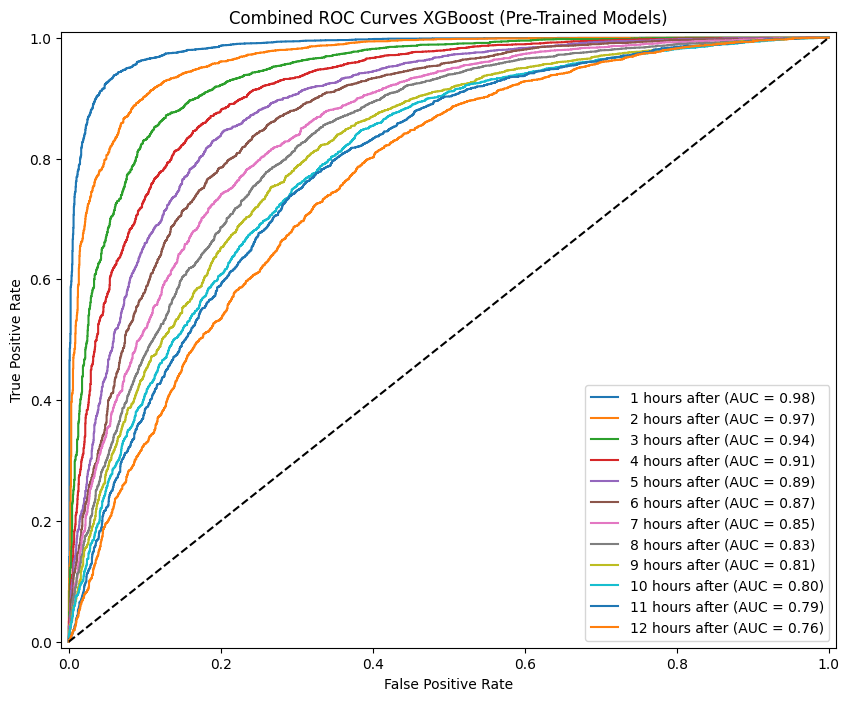

Averaged F1 Score: 0.85
Averaged ROC-AUC: 0.87
Predicted values have been saved to xgb_pred_stack.csv
Feature rankings have been saved to xgb_feature_rankings.csv


In [ ]:
"""
XGBoost Classifier Evaluation with Pre-Trained Models and Feature Importance Ranking
"""
#%% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

#%% Load the dataset
file_path = './data/data.csv'
data = pd.read_csv(file_path, index_col=0)

# Interpolate missing values in PM2.5
data['pm2.5'] = data['pm2.5'].interpolate()

# Generate future PM2.5 levels (1 to 12 hours ahead)
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode categorical column 'cbwd'
data = pd.get_dummies(data, columns=['cbwd'])

# Remove rows with missing values in PM2.5 predictions
data.dropna(
    subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)],
    inplace=True
)

# Split data into training (50%) and testing (35%) sets
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_test:]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

#%% Prepare training and test data
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

#%% Preprocessing: Scale numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on X_train and transform X_test
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Reconstruct X_train and X_test with scaled numerical columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns, index=X_test.index)

# Replace numerical columns in original X_test with scaled versions
X_test_final = X_test.copy()
X_test_final[numerical_columns] = X_test_scaled_df[numerical_columns]

# Define feature names
feature_names = X_test_final.columns.tolist()

#%% Initialize lists to store evaluation metrics and feature rankings
f1_scores = []
roc_aucs = []
predictions = {}
feature_rankings_list = []  # List to store feature rankings per hour

num_hours = 12  # Total hours to evaluate

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

#%% Evaluate pre-trained models for each hour
for i in range(1, num_hours + 1):
    print(f"\nEvaluating pre-trained model for {i} hour(s) after...")

    # Define target variable for the i-th hour
    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    # Load pre-trained model for the current hour
    model_path = f'./outputs/models/xgb_hour_{i}.joblib'
    try:
        classifier = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Model file {model_path} not found. Skipping hour {i}.")
        continue

    # Make predictions on the test data
    y_pred_test = classifier.predict(X_test_final)
    y_prob_test = classifier.predict_proba(X_test_final)[:, 1]

    # Store predictions
    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    # Calculate metrics
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store evaluation metrics
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Extract feature importances
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        # Pair feature names with their importances
        feature_importance = list(zip(feature_names, importances))
        # Sort features by importance
        feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)
        # Create a DataFrame for feature rankings of the current hour
        feature_rankings_df = pd.DataFrame(feature_importance_sorted, columns=['Feature', 'Importance'])
        feature_rankings_df['Rank'] = feature_rankings_df['Importance'].rank(method='dense', ascending=False).astype(int)
        feature_rankings_df.insert(0, 'Hour', f'Hour_{i}')
        feature_rankings_list.append(feature_rankings_df)
    else:
        print(f"Model for hour {i} does not have 'feature_importances_' attribute.")
        # Create an empty DataFrame for consistency
        feature_rankings_df = pd.DataFrame(columns=['Hour', 'Feature', 'Importance', 'Rank'])
        feature_rankings_list.append(feature_rankings_df)

    # Output the metrics for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # Generate ROC curve for the current hour
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

#%% Concatenate all feature rankings into a single DataFrame
if feature_rankings_list:
    all_feature_rankings = pd.concat(feature_rankings_list, ignore_index=True)
    # Reorder columns for better readability
    all_feature_rankings = all_feature_rankings[['Hour', 'Feature', 'Importance', 'Rank']]
else:
    all_feature_rankings = pd.DataFrame(columns=['Hour', 'Feature', 'Importance', 'Rank'])

#%% Plot a diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves XGBoost (Pre-Trained Models)')
plt.legend(loc="lower right")
plt.savefig('./outputs/xgb_stack.png')
plt.show()

#%% Output averaged metrics
if f1_scores:
    print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
else:
    print("No F1 scores to average.")

if roc_aucs:
    print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")
else:
    print("No ROC-AUC scores to average.")

#%% Save predictions to CSV
if predictions:
    prediction_df = pd.DataFrame(predictions)
    prediction_df.to_csv('./outputs/xgb_pred_stack.csv', index=False)
    print("Predicted values have been saved to xgb_pred_stack.csv")
else:
    print("No predictions to save.")

#%% Save feature rankings to CSV
if not all_feature_rankings.empty:
    all_feature_rankings.to_csv('./outputs/xgb_feature_rankings.csv', index=False)
    print("Feature rankings have been saved to xgb_feature_rankings.csv")
else:
    print("No feature rankings to save.")

Training Data Size: 21894
Test Data Size: 6569

Evaluating pre-trained model for 1 hour(s) after...
1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98

Evaluating pre-trained model for 2 hour(s) after...
2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.96

Evaluating pre-trained model for 3 hour(s) after...
3 hours after: Test F1 Score: 0.89, Test ROC-AUC: 0.94

Evaluating pre-trained model for 4 hour(s) after...
4 hours after: Test F1 Score: 0.88, Test ROC-AUC: 0.92

Evaluating pre-trained model for 5 hour(s) after...
5 hours after: Test F1 Score: 0.87, Test ROC-AUC: 0.90

Evaluating pre-trained model for 6 hour(s) after...
6 hours after: Test F1 Score: 0.86, Test ROC-AUC: 0.88

Evaluating pre-trained model for 7 hour(s) after...
7 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.86

Evaluating pre-trained model for 8 hour(s) after...
8 hours after: Test F1 Score: 0.83, Test ROC-AUC: 0.84

Evaluating pre-trained model for 9 hour(s) after...
9 hours after: Test F1 Score: 0.82, 

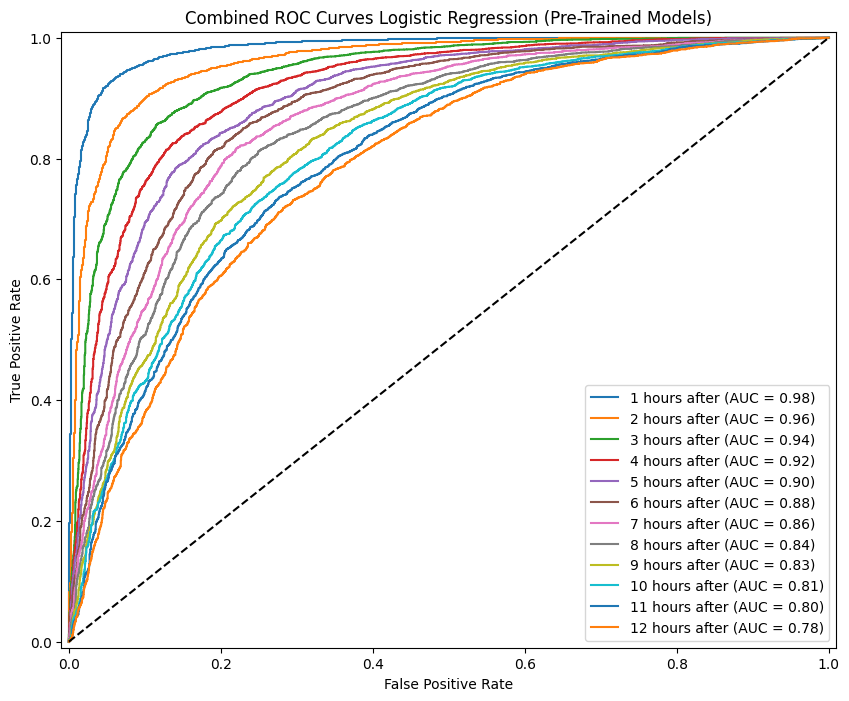

Averaged F1 Score: 0.86
Averaged ROC-AUC: 0.87
Predicted values have been saved to logistic_pretrained_pred.csv
Feature rankings have been saved to logistic_feature_rankings.csv


In [235]:
"""
Logistic Regression Classifier Evaluation with Pre-Trained Models and Feature Ranking (Saved as CSV)
"""
#%% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

#%% Load the dataset
file_path = './data/data.csv'
data = pd.read_csv(file_path, index_col=0)

# Interpolate missing values in PM2.5
data['pm2.5'] = data['pm2.5'].interpolate()

# Generate future PM2.5 levels (1 to 12 hours ahead)
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode categorical column 'cbwd'
data = pd.get_dummies(data, columns=['cbwd'])

# Remove rows with missing values in PM2.5 predictions
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

# Split data into training (50%) and testing (35%) sets
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_test:]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

#%% Prepare training and test data
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

#%% Recreate the preprocessing pipeline with PolynomialFeatures
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numerical_columns)
    ],
    remainder='passthrough'  # Keep other columns as is
)

#%% Fit the preprocessor on training data and transform test data
preprocessor.fit(X_train)  # Fit only on training data
X_test_preprocessed = preprocessor.transform(X_test)  # Transform test data using the fitted preprocessor

#%% Retrieve feature names from preprocessing
# Extract polynomial feature names
poly_feature_names = preprocessor.named_transformers_['poly']['poly'].get_feature_names_out(numerical_columns)
# Extract passthrough (non-numerical) feature names
passthrough_columns = list(X_test.drop(columns=numerical_columns).columns)
# Combine all feature names
feature_names = list(poly_feature_names) + passthrough_columns

#%% Initialize lists to store evaluation metrics and feature rankings
f1_scores = []
roc_aucs = []
predictions = {}
feature_rankings_list = []  # List to store feature rankings per hour

num_hours = 12  # Total hours to evaluate

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

#%% Evaluate pre-trained models for each hour
for i in range(1, num_hours + 1):
    print(f"\nEvaluating pre-trained model for {i} hour(s) after...")

    # Define target variable for the i-th hour
    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    # Load pre-trained model for the current hour
    model_path = f'./outputs/models/logistic_hour_{i}.joblib'
    try:
        classifier = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Model file {model_path} not found. Skipping hour {i}.")
        continue

    # Make predictions on the preprocessed test data
    y_pred_test = classifier.predict(X_test_preprocessed)
    y_prob_test = classifier.predict_proba(X_test_preprocessed)[:, 1]

    # Store predictions
    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    # Calculate metrics
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store evaluation metrics
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Rank features based on their coefficients
    if hasattr(classifier, 'coef_'):
        coefficients = classifier.coef_[0]  # Coefficients for the Logistic Regression model
        # Pair feature names with their coefficients
        feature_importance = sorted(
            zip(feature_names, coefficients),
            key=lambda x: abs(x[1]),
            reverse=True
        )
        # Create a DataFrame for feature rankings of the current hour
        feature_rankings_df = pd.DataFrame(feature_importance, columns=['Feature', 'Coefficient'])
        feature_rankings_df['AbsoluteCoefficient'] = feature_rankings_df['Coefficient'].abs()
        feature_rankings_df['Rank'] = feature_rankings_df['AbsoluteCoefficient'].rank(method='dense', ascending=False).astype(int)
        feature_rankings_df.insert(0, 'Hour', f'Hour_{i}')
        feature_rankings_list.append(feature_rankings_df)
    else:
        print(f"Model for hour {i} does not have coefficients to rank features.")
        # Create an empty DataFrame for consistency
        feature_rankings_df = pd.DataFrame(columns=['Hour', 'Feature', 'Coefficient', 'AbsoluteCoefficient', 'Rank'])
        feature_rankings_list.append(feature_rankings_df)

    # Output the metrics for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # Generate ROC curve for the current hour
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

#%% Concatenate all feature rankings into a single DataFrame
if feature_rankings_list:
    all_feature_rankings = pd.concat(feature_rankings_list, ignore_index=True)
    # Reorder columns for better readability
    all_feature_rankings = all_feature_rankings[['Hour', 'Feature', 'Coefficient', 'AbsoluteCoefficient', 'Rank']]
else:
    all_feature_rankings = pd.DataFrame(columns=['Hour', 'Feature', 'Coefficient', 'AbsoluteCoefficient', 'Rank'])

#%% Plot a diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves Logistic Regression (Pre-Trained Models)')
plt.legend(loc="lower right")
plt.savefig('./outputs/logistic_stack.png')
plt.show()

#%% Output averaged metrics
if f1_scores:
    print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
else:
    print("No F1 scores to average.")

if roc_aucs:
    print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")
else:
    print("No ROC-AUC scores to average.")

#%% Save predictions to CSV
if predictions:
    prediction_df = pd.DataFrame(predictions)
    prediction_df.to_csv('./outputs/logistic_pred_stack.csv', index=False)
    print("Predicted values have been saved to logistic_pretrained_pred.csv")
else:
    print("No predictions to save.")

#%% Save feature rankings to CSV
if not all_feature_rankings.empty:
    all_feature_rankings.to_csv('./outputs/logistic_feature_rankings.csv', index=False)
    print("Feature rankings have been saved to logistic_feature_rankings.csv")
else:
    print("No feature rankings to save.")


Missing rows before: 36
Training Data Size: 21894
Test Data Size: 6569

Evaluating pre-trained model for 1 hour(s) after...
1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98

Evaluating pre-trained model for 2 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.96

Evaluating pre-trained model for 3 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


3 hours after: Test F1 Score: 0.90, Test ROC-AUC: 0.94

Evaluating pre-trained model for 4 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


4 hours after: Test F1 Score: 0.88, Test ROC-AUC: 0.92

Evaluating pre-trained model for 5 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


5 hours after: Test F1 Score: 0.87, Test ROC-AUC: 0.89

Evaluating pre-trained model for 6 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


6 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.87

Evaluating pre-trained model for 7 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


7 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.86

Evaluating pre-trained model for 8 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


8 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.84

Evaluating pre-trained model for 9 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


9 hours after: Test F1 Score: 0.83, Test ROC-AUC: 0.82

Evaluating pre-trained model for 10 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


10 hours after: Test F1 Score: 0.82, Test ROC-AUC: 0.81

Evaluating pre-trained model for 11 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


11 hours after: Test F1 Score: 0.81, Test ROC-AUC: 0.79

Evaluating pre-trained model for 12 hour(s) after...


c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


12 hours after: Test F1 Score: 0.80, Test ROC-AUC: 0.78


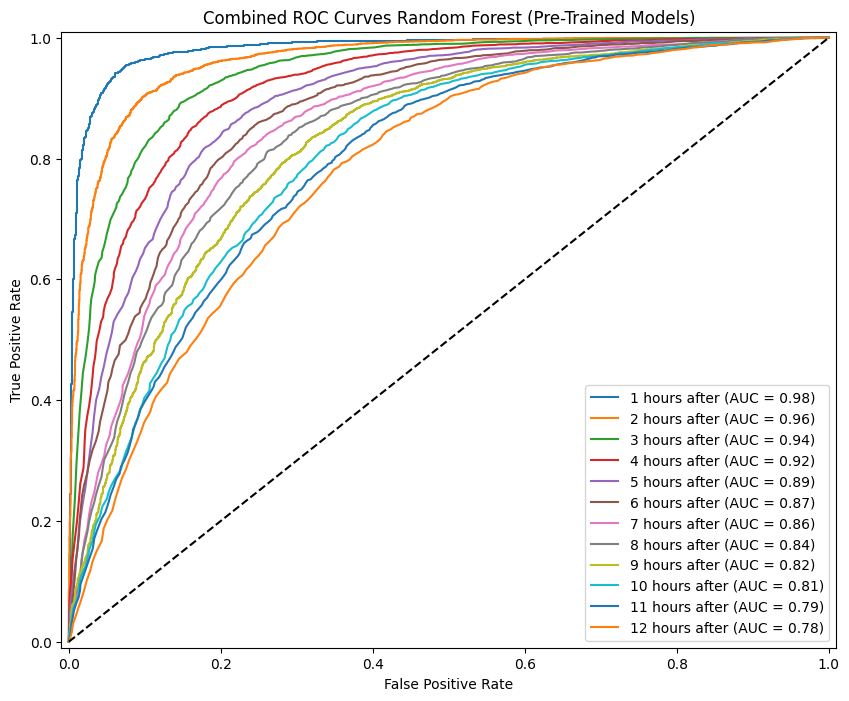

Averaged F1 Score: 0.86
Averaged ROC-AUC: 0.87
Predicted values have been saved to rf_pred_stack.csv
Feature rankings have been saved to rf_feature_rankings.csv


In [240]:
"""
Random Forest Classifier Evaluation with Pre-Trained Models and Feature Importance Ranking
"""
#%% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

#%% Load the dataset
file_path = './data/data.csv'
data = pd.read_csv(file_path, index_col=0)

# Interpolate missing values in PM2.5
data['pm2.5'] = data['pm2.5'].interpolate()

# Generate future PM2.5 levels (1 to 12 hours ahead)
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode categorical column 'cbwd'
data = pd.get_dummies(data, columns=['cbwd'])

# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f"Missing rows before: {missing_rows_before}")

# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(
    subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)],
    inplace=True
)

# Split data into training (50%) and testing (35%) sets
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_test:]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

#%% Prepare training and test data
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

#%% Preprocessing: Scale numerical features
scaler = StandardScaler()

# Fit the scaler on X_train and transform X_test
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Reconstruct X_train and X_test with scaled numerical columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns, index=X_test.index)

# Replace numerical columns in original X_test with scaled versions
X_test_final = X_test.copy()
X_test_final[numerical_columns] = X_test_scaled_df[numerical_columns]

# Define feature names
feature_names = X_test_final.columns.tolist()

#%% Initialize lists to store evaluation metrics and feature rankings
f1_scores = []
roc_aucs = []
predictions = {}
feature_rankings_list = []  # List to store feature rankings per hour

num_hours = 12  # Total hours to evaluate

#%% Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

#%% Evaluate pre-trained models for each hour
for i in range(1, num_hours + 1):
    print(f"\nEvaluating pre-trained model for {i} hour(s) after...")

    # Define target variable for the i-th hour
    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    # Load pre-trained model for the current hour
    model_path = f'./outputs/models/rf_hour_{i}.joblib'
    try:
        classifier = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Model file {model_path} not found. Skipping hour {i}.")
        continue

    # Make predictions on the test data
    y_pred_test = classifier.predict(X_test_final)
    y_prob_test = classifier.predict_proba(X_test_final)[:, 1]

    # Store predictions
    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    # Calculate metrics
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store evaluation metrics
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Extract and rank feature importances
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        # Pair feature names with their importances
        feature_importance = list(zip(feature_names, importances))
        # Sort features by importance
        feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)
        # Create a DataFrame for feature rankings of the current hour
        feature_rankings_df = pd.DataFrame(feature_importance_sorted, columns=['Feature', 'Importance'])
        feature_rankings_df['Rank'] = feature_rankings_df['Importance'].rank(method='dense', ascending=False).astype(int)
        feature_rankings_df.insert(0, 'Hour', f'Hour_{i}')
        feature_rankings_list.append(feature_rankings_df)
    else:
        print(f"Model for hour {i} does not have 'feature_importances_' attribute.")
        # Create an empty DataFrame for consistency
        feature_rankings_df = pd.DataFrame(columns=['Hour', 'Feature', 'Importance', 'Rank'])
        feature_rankings_list.append(feature_rankings_df)

    # Output the metrics for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # Generate ROC curve for the current hour
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

#%% Concatenate all feature rankings into a single DataFrame
if feature_rankings_list:
    all_feature_rankings = pd.concat(feature_rankings_list, ignore_index=True)
    # Reorder columns for better readability
    all_feature_rankings = all_feature_rankings[['Hour', 'Feature', 'Importance', 'Rank']]
else:
    all_feature_rankings = pd.DataFrame(columns=['Hour', 'Feature', 'Importance', 'Rank'])

#%% Plot a diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves Random Forest (Pre-Trained Models)')
plt.legend(loc="lower right")
plt.savefig('./outputs/rf_pretrained.png')
plt.show()

#%% Output averaged metrics
if f1_scores:
    print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
else:
    print("No F1 scores to average.")

if roc_aucs:
    print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")
else:
    print("No ROC-AUC scores to average.")

#%% Save predictions to CSV
if predictions:
    prediction_df = pd.DataFrame(predictions)
    prediction_df.to_csv('./outputs/rf_pred_stack.csv', index=False)
    print("Predicted values have been saved to rf_pred_stack.csv")
else:
    print("No predictions to save.")

#%% Save feature rankings to CSV
if not all_feature_rankings.empty:
    all_feature_rankings.to_csv('./outputs/rf_feature_rankings.csv', index=False)
    print("Feature rankings have been saved to rf_feature_rankings.csv")
else:
    print("No feature rankings to save.")


In [253]:
# Calculate the index to split the data at 85% for training and 15% for testing
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

# Split the datasplit_index into training and test sets
data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_train:split_index_test]
data_test_stack = data.iloc[split_index_test:]

In [ ]:
import pandas as pd

# List of classifiers
classifiers = ['svc', 'rf', 'nn', 'xgb', 'logistic']
predictions = {}

# Load predictions from CSV files
for clf in classifiers:
    predictions[clf] = pd.read_csv(f'./outputs/{clf}_pred.csv')

hourly_predictions = []

for hour in range(1, 13):
    df_hour = pd.DataFrame()
    for clf in classifiers:
        # Get predictions for the current hour
        df_hour[clf] = predictions[clf].loc[:, f'Hour_{hour}_Predictions'].reset_index(drop=True)
    # Add the true label from data_test
    df_hour['True Label'] = data_test[f'pm2.5_{hour}_hour_after'].reset_index(drop=True)
    # Append the DataFrame to the list
    hourly_predictions.append(df_hour)
    print(df_hour)


# Load predictions from CSV files
for clf in classifiers:
    predictions[clf] = pd.read_csv(f'./outputs/{clf}_pred_stack.csv')

hourly_predictions_test = []

for hour in range(1, 13):
    df_hour = pd.DataFrame()
    for clf in classifiers:
        # Get predictions for the current hour
        df_hour[clf] = predictions[clf].loc[:, f'Hour_{hour}_Predictions'].reset_index(drop=True)
    # Add the true label from data_test
    df_hour['True Label'] = data_test_stack[f'pm2.5_{hour}_hour_after'].reset_index(drop=True)
    # Append the DataFrame to the list
    hourly_predictions_test.append(df_hour)

       svc  rf  nn  xgb  logistic  True Label
0        0   0   0    0         0        17.0
1        0   0   0    0         0        17.0
2        0   0   0    0         0        19.0
3        0   0   0    0         0        12.0
4        0   0   0    0         0         9.0
...    ...  ..  ..  ...       ...         ...
15320    1   1   1    1         1        63.0
15321    1   1   1    1         1        52.0
15322    0   1   0    1         1        64.0
15323    1   1   1    1         1        48.0
15324    0   0   0    0         0        69.0

[15325 rows x 6 columns]
       svc  rf  nn  xgb  logistic  True Label
0        0   0   0    0         0        17.0
1        0   0   0    0         0        19.0
2        0   0   0    0         0        12.0
3        0   0   0    0         0         9.0
4        0   0   0    0         0        13.0
...    ...  ..  ..  ...       ...         ...
15320    1   1   1    1         1        52.0
15321    0   1   1    1         1        64.0
15322   


Processing Hour 1...

Processing Hour 2...

Processing Hour 3...

Processing Hour 4...

Processing Hour 5...

Processing Hour 6...

Processing Hour 7...

Processing Hour 8...

Processing Hour 9...

Processing Hour 10...

Processing Hour 11...

Processing Hour 12...


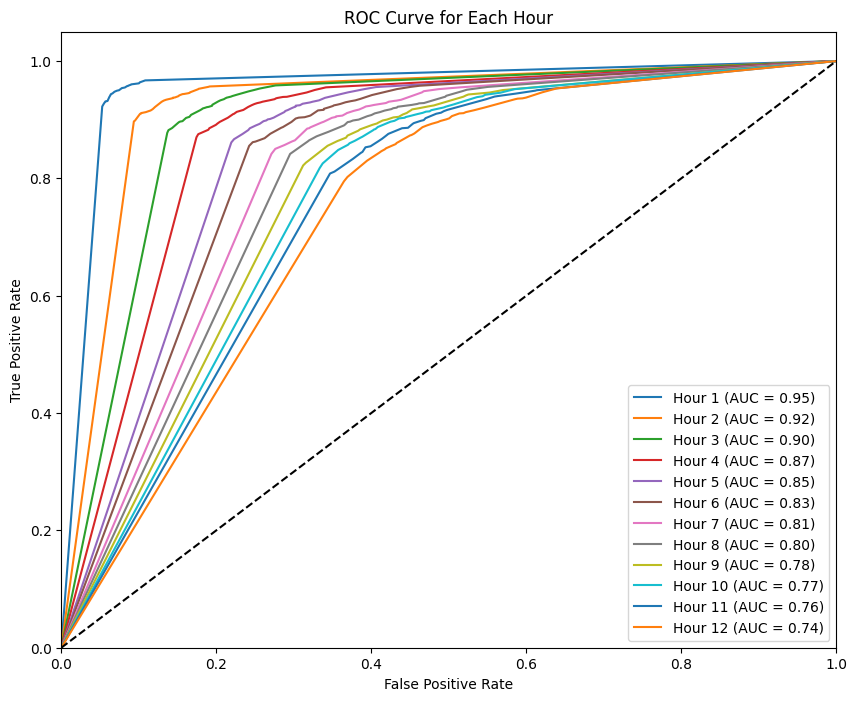

Hour 1: F1 Score = 0.95
Hour 2: F1 Score = 0.92
Hour 3: F1 Score = 0.90
Hour 4: F1 Score = 0.89
Hour 5: F1 Score = 0.87
Hour 6: F1 Score = 0.86
Hour 7: F1 Score = 0.85
Hour 8: F1 Score = 0.83
Hour 9: F1 Score = 0.83
Hour 10: F1 Score = 0.82
Hour 11: F1 Score = 0.82
Hour 12: F1 Score = 0.81


In [258]:
"""stacked"""
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store f1 scores and ROC curve data
f1_scores = []
roc_curves = []
best_params = []  # To store best parameters for each hour

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Iterate over each hour
for hour in range(12):
    print(f"\nProcessing Hour {hour + 1}...")
    
    # Get the dataframe for the current hour
    df_hour = hourly_predictions[hour]
    df_hour_test = hourly_predictions_test[hour]

    # Define features and label
    X_train = df_hour.drop(columns=['True Label'])
    y_train = df_hour['True Label'] >= 50
    X_test = df_hour_test.drop(columns=['True Label'])
    y_test = df_hour_test['True Label'] >= 50
    
    # Initialize the XGBoost model
    model = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,
        verbose=0
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)
    # print(f"Best parameters for Hour {hour + 1}: {grid_search.best_params_}")
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'Hour {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Hour')
plt.legend(loc='lower right')
plt.show()

# Print the f1 scores
for i, f1 in enumerate(f1_scores):
    print(f'Hour {i+1}: F1 Score = {f1:.2f}')
